In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import vaderSentiment.vaderSentiment as vaderSentiment
import datetime
import pandas as pd

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
pwd = os.getcwd()
filepath_aapl = os.path.join(pwd, 'AAPL.csv')
print(filepath_aapl)
filepath_amzn = os.path.join(pwd, 'AMZN.csv')
print(filepath_amzn)
filepath_goog = os.path.join(pwd, 'GOOG.csv')
print(filepath_goog)
filepath_googl = os.path.join(pwd, 'GOOGL.csv')
print(filepath_googl)
filepath_tsla = os.path.join(pwd, 'TSLA.csv')
print(filepath_tsla)
aapl = pd.read_csv(filepath_aapl, index_col='Date')
amzn = pd.read_csv(filepath_amzn, index_col='Date')
goog = pd.read_csv(filepath_goog, index_col='Date')
googl = pd.read_csv(filepath_googl, index_col='Date')
tsla = pd.read_csv(filepath_tsla, index_col='Date')

c:\Users\harsh\Desktop\Using Tweets to predict Stock Movement\AAPL.csv
c:\Users\harsh\Desktop\Using Tweets to predict Stock Movement\AMZN.csv
c:\Users\harsh\Desktop\Using Tweets to predict Stock Movement\GOOG.csv
c:\Users\harsh\Desktop\Using Tweets to predict Stock Movement\GOOGL.csv
c:\Users\harsh\Desktop\Using Tweets to predict Stock Movement\TSLA.csv


In [2]:
def changeMaker(data):
    x = []
    data["prevClose"] = data['Adj Close'].shift(1)
    data['change'] = data[['prevClose','Adj Close']].pct_change(axis=1)['Adj Close'] 
    return data

def upDown(data):
    x = []
    for i in data:
        if i > 0:
            x.append("Positive")
        elif i < 0:
            x.append("Negative")
        else:
            x.append("Negative")
    return x


aapl= changeMaker(aapl)
aapl['upDown'] = upDown(aapl['change'])
amzn= changeMaker(amzn)
amzn['upDown'] = upDown(amzn['change'])
goog= changeMaker(goog)
goog['upDown'] = upDown(goog['change'])
googl= changeMaker(googl)
googl['upDown'] = upDown(googl['change'])
tsla= changeMaker(tsla)
tsla['upDown'] = upDown(tsla['change'])

def resetIndex_and_changeDateType(df):
    temp = df.copy()
    temp.reset_index(inplace=True)
    temp['Date'] = pd.to_datetime(temp['Date'])
    return temp

aapl = resetIndex_and_changeDateType(aapl)
tsla = resetIndex_and_changeDateType(tsla)
amzn = resetIndex_and_changeDateType(amzn)
goog = resetIndex_and_changeDateType(goog)
googl = resetIndex_and_changeDateType(googl)

In [3]:
basic_features = ['Adj Close']
complex_features = ['Adj Close', 'Open', 'High', 'Low']

def onehot_encode(df, column_dict):
    df = df.copy()
    for column, prefix in column_dict.items():
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

def preprocess_inputs(df, scaler, wanted_features):
    df = df.copy()

    # Split df into X and y
    y = df['upDown'].copy()
    X = df.drop(columns=['upDown', 'Date'], axis=1).copy()
    
    # Scale and make my dataset
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    X = X[wanted_features]
    return X, y
    

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Just MinMax

# Basic Features
X_applb, y_applb = preprocess_inputs(aapl, MinMaxScaler(), basic_features)
X_tslab, y_tslab = preprocess_inputs(tsla, MinMaxScaler(), basic_features)
X_amznb, y_amznb = preprocess_inputs(amzn, MinMaxScaler(), basic_features)
X_googb, y_googb = preprocess_inputs(goog, MinMaxScaler(), basic_features)
X_googlb, y_googlb = preprocess_inputs(googl, MinMaxScaler(), basic_features)

# Complex Features
X_appl, y_appl = preprocess_inputs(aapl, MinMaxScaler(), complex_features)
X_tsla, y_tsla = preprocess_inputs(tsla, MinMaxScaler(), complex_features)
X_amzn, y_amzn = preprocess_inputs(amzn, MinMaxScaler(), complex_features)
X_goog, y_goog = preprocess_inputs(goog, MinMaxScaler(), complex_features)
X_googl, y_googl = preprocess_inputs(googl, MinMaxScaler(), complex_features)

In [4]:
from sklearn.model_selection import train_test_split

# splitting my data into test and train data 
def split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=42)

    return X_train, X_test, y_train, y_test

#Basic Features
X_train_applb, X_test_applb, y_train_applb, y_test_applb = split(X_applb, y_applb)
X_train_tslab, X_test_tslab, y_train_tslab, y_test_tslab = split(X_tslab, y_tslab)
X_train_amznb, X_test_amznb, y_train_amznb, y_test_amznb = split(X_amznb, y_amznb)
X_train_googb, X_test_googb, y_train_googb, y_test_googb = split(X_googb, y_googb)
X_train_googlb, X_test_googlb, y_train_googlb, y_test_googlb = split(X_googlb, y_googlb)

#Complex Features
X_train_applc, X_test_applc, y_train_applc, y_test_applc = split(X_appl, y_appl)
X_train_tslac, X_test_tslac, y_train_tslac, y_test_tslac = split(X_tsla, y_tsla)
X_train_amznc, X_test_amznc, y_train_amznc, y_test_amznc = split(X_amzn, y_amzn)
X_train_googc, X_test_googc, y_train_googc, y_test_googc = split(X_goog, y_goog)
X_train_googlc, X_test_googlc, y_train_googlc, y_test_googlc = split(X_googl, y_googl)

### Alg

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import svm 
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
#import SVR
from sklearn.svm import SVR

def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    dfs = []
    models = [
            ('LogReg', LogisticRegression()), 
            ('RF', RandomForestClassifier()),
            # ('DT', DecisionTreeClassifier(random_state=42)),
            ('SVM', svm.SVC(probability=True)), 
            ('GNB', GaussianNB()),
            ('GB', GradientBoostingClassifier(n_estimators=5, learning_rate=1.0, max_depth=1, random_state=0)),
            ]
    results = []
    names = []
    scoring = ['accuracy', 'f1_weighted', 'roc_auc']
    target_names = ['malignant', 'benign']
    for name, model in models:
        #performing k-fold cross validation
        knfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=knfold, scoring=scoring)
        #training and testing the model
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        # showing results
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)
    return final

## ML

### Algs

In [6]:
print('Apple Basic No Sent')
final_aapl = run_exps(X_train_applb, y_train_applb, X_test_applb, y_test_applb)
print('Tesla Basic No Sent')
final_tsla = run_exps(X_train_tslab, y_train_tslab, X_test_tslab, y_test_tslab)
print('Amazon Basic No Sent')
final_amzn = run_exps(X_train_amznb, y_train_amznb, X_test_amznb, y_test_amznb)
print('Goog Basic No Sent')
final_goog = run_exps(X_train_googb, y_train_googb, X_test_googb, y_test_googb)
print('Googl Basic No Sent')
final_googl = run_exps(X_train_googlb, y_train_googlb, X_test_googlb, y_test_googlb)

print('Apple Complex No Sent')
final_aaplc = run_exps(X_train_applc, y_train_applc, X_test_applc, y_test_applc)
print('Tesla Complex No Sent')
final_tslac = run_exps(X_train_tslac, y_train_tslac, X_test_tslac, y_test_tslac)
print('Amazon Complex No Sent')
final_amznc = run_exps(X_train_amznc, y_train_amznc, X_test_amznc, y_test_amznc)
print('Goog Complex No Sent')
final_googc = run_exps(X_train_googc, y_train_googc, X_test_googc, y_test_googc)
print('Googl Complex No Sent')
final_googlc = run_exps(X_train_googlc, y_train_googlc, X_test_googlc, y_test_googlc)

Apple Basic No Sent
LogReg
              precision    recall  f1-score   support

   malignant       0.00      0.00      0.00       170
      benign       0.55      1.00      0.71       208

    accuracy                           0.55       378
   macro avg       0.28      0.50      0.35       378
weighted avg       0.30      0.55      0.39       378



C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF
              precision    recall  f1-score   support

   malignant       0.44      0.51      0.47       170
      benign       0.54      0.47      0.50       208

    accuracy                           0.49       378
   macro avg       0.49      0.49      0.49       378
weighted avg       0.50      0.49      0.49       378

SVM
              precision    recall  f1-score   support

   malignant       0.44      0.32      0.37       170
      benign       0.55      0.66      0.60       208

    accuracy                           0.51       378
   macro avg       0.49      0.49      0.49       378
weighted avg       0.50      0.51      0.50       378

GNB
              precision    recall  f1-score   support

   malignant       0.00      0.00      0.00       170
      benign       0.55      1.00      0.71       208

    accuracy                           0.55       378
   macro avg       0.28      0.50      0.35       378
weighted avg       0.30      0.55      0.39       378

GB
     

C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

   malignant       0.52      0.47      0.49       178
      benign       0.56      0.60      0.58       200

    accuracy                           0.54       378
   macro avg       0.54      0.54      0.54       378
weighted avg       0.54      0.54      0.54       378

RF
              precision    recall  f1-score   support

   malignant       0.47      0.47      0.47       178
      benign       0.53      0.53      0.53       200

    accuracy                           0.50       378
   macro avg       0.50      0.50      0.50       378
weighted avg       0.50      0.50      0.50       378

SVM
              precision    recall  f1-score   support

   malignant       0.50      0.78      0.61       178
      benign       0.60      0.29      0.40       200

    accuracy                           0.52       378
   macro avg       0.55      0.54      0.50       378
weighted avg       0.55      0.52      0.50       378

GNB
        

C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

   malignant       0.00      0.00      0.00       170
      benign       0.55      1.00      0.71       208

    accuracy                           0.55       378
   macro avg       0.28      0.50      0.35       378
weighted avg       0.30      0.55      0.39       378

RF
              precision    recall  f1-score   support

   malignant       0.44      0.42      0.43       170
      benign       0.54      0.57      0.56       208

    accuracy                           0.50       378
   macro avg       0.49      0.49      0.49       378
weighted avg       0.50      0.50      0.50       378

SVM
              precision    recall  f1-score   support

   malignant       0.00      0.00      0.00       170
      benign       0.55      1.00      0.71       208

    accuracy                           0.55       378
   macro avg       0.28      0.50      0.35       378
weighted avg       0.30      0.55      0.39       378

GNB
        

C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1

              precision    recall  f1-score   support

   malignant       0.00      0.00      0.00       165
      benign       0.56      1.00      0.72       213

    accuracy                           0.56       378
   macro avg       0.28      0.50      0.36       378
weighted avg       0.32      0.56      0.41       378

RF
              precision    recall  f1-score   support

   malignant       0.45      0.46      0.45       165
      benign       0.57      0.56      0.57       213

    accuracy                           0.52       378
   macro avg       0.51      0.51      0.51       378
weighted avg       0.52      0.52      0.52       378

SVM
              precision    recall  f1-score   support

   malignant       0.00      0.00      0.00       165
      benign       0.56      1.00      0.72       213

    accuracy                           0.56       378
   macro avg       0.28      0.50      0.36       378
weighted avg       0.32      0.56      0.41       378

GNB
        

C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1

LogReg
              precision    recall  f1-score   support

   malignant       0.00      0.00      0.00       169
      benign       0.55      1.00      0.71       209

    accuracy                           0.55       378
   macro avg       0.28      0.50      0.36       378
weighted avg       0.31      0.55      0.39       378



C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF
              precision    recall  f1-score   support

   malignant       0.47      0.51      0.49       169
      benign       0.58      0.53      0.55       209

    accuracy                           0.52       378
   macro avg       0.52      0.52      0.52       378
weighted avg       0.53      0.52      0.53       378

SVM
              precision    recall  f1-score   support

   malignant       0.00      0.00      0.00       169
      benign       0.55      1.00      0.71       209

    accuracy                           0.55       378
   macro avg       0.28      0.50      0.36       378
weighted avg       0.31      0.55      0.39       378

GNB
              precision    recall  f1-score   support

   malignant       0.00      0.00      0.00       169
      benign       0.55      1.00      0.71       209

    accuracy                           0.55       378
   macro avg       0.28      0.50      0.36       378
weighted avg       0.31      0.55      0.39       378

GB
     

C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1

LogReg
              precision    recall  f1-score   support

   malignant       0.00      0.00      0.00       170
      benign       0.55      1.00      0.71       208

    accuracy                           0.55       378
   macro avg       0.28      0.50      0.35       378
weighted avg       0.30      0.55      0.39       378



C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF
              precision    recall  f1-score   support

   malignant       0.62      0.56      0.59       170
      benign       0.67      0.72      0.69       208

    accuracy                           0.65       378
   macro avg       0.65      0.64      0.64       378
weighted avg       0.65      0.65      0.65       378

SVM
              precision    recall  f1-score   support

   malignant       0.00      0.00      0.00       170
      benign       0.55      1.00      0.71       208

    accuracy                           0.55       378
   macro avg       0.28      0.50      0.35       378
weighted avg       0.30      0.55      0.39       378

GNB
              precision    recall  f1-score   support

   malignant       0.43      0.39      0.41       170
      benign       0.53      0.57      0.55       208

    accuracy                           0.49       378
   macro avg       0.48      0.48      0.48       378
weighted avg       0.49      0.49      0.49       378

GB
     

C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LogReg
              precision    recall  f1-score   support

   malignant       0.53      0.47      0.50       178
      benign       0.57      0.62      0.60       200

    accuracy                           0.55       378
   macro avg       0.55      0.55      0.55       378
weighted avg       0.55      0.55      0.55       378

RF
              precision    recall  f1-score   support

   malignant       0.73      0.74      0.74       178
      benign       0.77      0.76      0.76       200

    accuracy                           0.75       378
   macro avg       0.75      0.75      0.75       378
weighted avg       0.75      0.75      0.75       378

SVM
              precision    recall  f1-score   support

   malignant       0.51      0.53      0.52       178
      benign       0.56      0.54      0.55       200

    accuracy                           0.53       378
   macro avg       0.53      0.53      0.53       378
weighted avg       0.54      0.53      0.53       378

GNB
 

C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF
              precision    recall  f1-score   support

   malignant       0.66      0.60      0.63       170
      benign       0.70      0.75      0.72       208

    accuracy                           0.68       378
   macro avg       0.68      0.67      0.67       378
weighted avg       0.68      0.68      0.68       378

SVM
              precision    recall  f1-score   support

   malignant       0.38      0.07      0.12       170
      benign       0.54      0.90      0.68       208

    accuracy                           0.53       378
   macro avg       0.46      0.49      0.40       378
weighted avg       0.47      0.53      0.43       378

GNB
              precision    recall  f1-score   support

   malignant       0.38      0.09      0.14       170
      benign       0.54      0.88      0.67       208

    accuracy                           0.53       378
   macro avg       0.46      0.49      0.41       378
weighted avg       0.47      0.53      0.43       378

GB
     

C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF
              precision    recall  f1-score   support

   malignant       0.67      0.72      0.69       165
      benign       0.77      0.73      0.75       213

    accuracy                           0.72       378
   macro avg       0.72      0.72      0.72       378
weighted avg       0.73      0.72      0.73       378

SVM
              precision    recall  f1-score   support

   malignant       0.50      0.04      0.07       165
      benign       0.57      0.97      0.72       213

    accuracy                           0.56       378
   macro avg       0.53      0.50      0.39       378
weighted avg       0.54      0.56      0.43       378

GNB
              precision    recall  f1-score   support

   malignant       0.50      0.22      0.31       165
      benign       0.58      0.83      0.68       213

    accuracy                           0.56       378
   macro avg       0.54      0.53      0.50       378
weighted avg       0.54      0.56      0.52       378

GB
     

C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

   malignant       0.00      0.00      0.00       169
      benign       0.55      1.00      0.71       209

    accuracy                           0.55       378
   macro avg       0.28      0.50      0.36       378
weighted avg       0.31      0.55      0.39       378

RF
              precision    recall  f1-score   support

   malignant       0.66      0.68      0.67       169
      benign       0.73      0.71      0.72       209

    accuracy                           0.70       378
   macro avg       0.70      0.70      0.70       378
weighted avg       0.70      0.70      0.70       378

SVM
              precision    recall  f1-score   support

   malignant       1.00      0.01      0.01       169
      benign       0.55      1.00      0.71       209

    accuracy                           0.56       378
   macro avg       0.78      0.50      0.36       378
weighted avg       0.75      0.56      0.40       378

GNB
        

C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
def metrics(final):
    bootstraps = []
    for model in list(set(final.model.values)):
        model_df = final.loc[final.model == model]
        bootstrap = model_df.sample(n=30, replace=True)
        bootstraps.append(bootstrap)
            
    bootstrap_df = pd.concat(bootstraps, ignore_index=True)
    results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
    time_metrics = ['fit_time','score_time'] # fit time metrics

    ## PERFORMANCE METRICS
    results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
    results_long_nofit = results_long_nofit.sort_values(by='values')

    ## TIME METRICS
    results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
    results_long_fit = results_long_fit.sort_values(by='values')

    return results_long_nofit, results_long_fit

aaplnofitb, aaplfitb = metrics(final_aapl)
tslanofitb, tslafitb = metrics(final_tsla)
amznnofitb, amznfitb = metrics(final_amzn)
goognofitb, googfitb = metrics(final_goog)
googlnofitb, googlfitb = metrics(final_googl)

aaplnofitc, aaplfitc = metrics(final_aaplc)
tslanofitc, tslafitc = metrics(final_tslac)
amznnofitc, amznfitc = metrics(final_amznc)
goognofitc, googfitc = metrics(final_googc)
googlnofitc, googlfitc = metrics(final_googlc)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot(results_long_nofit, name):
    plt.figure(figsize=(20, 12))
    sns.set(font_scale=2.5)
    g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
    # plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Comparison of Models for ' + name)
# plt.savefig('./benchmark_models_performance.png',dpi=300)

In [9]:
print(sns.__version__)

0.11.2


### Basic

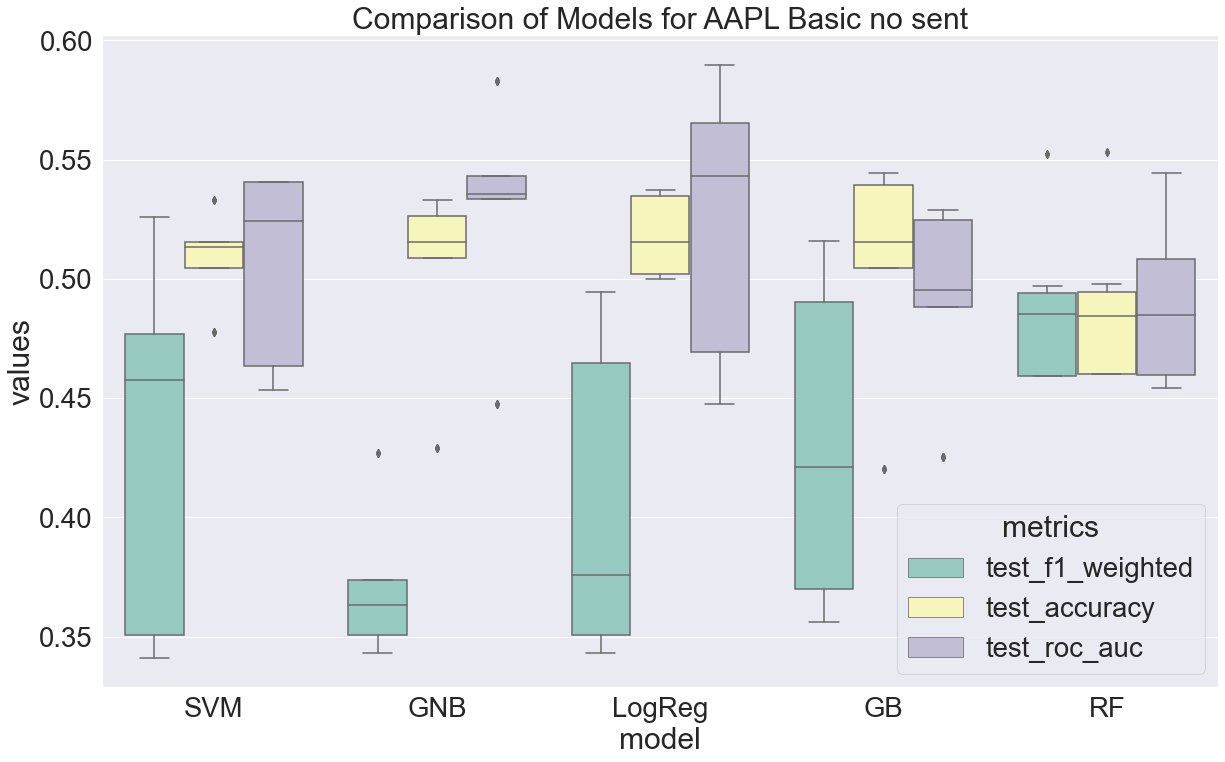

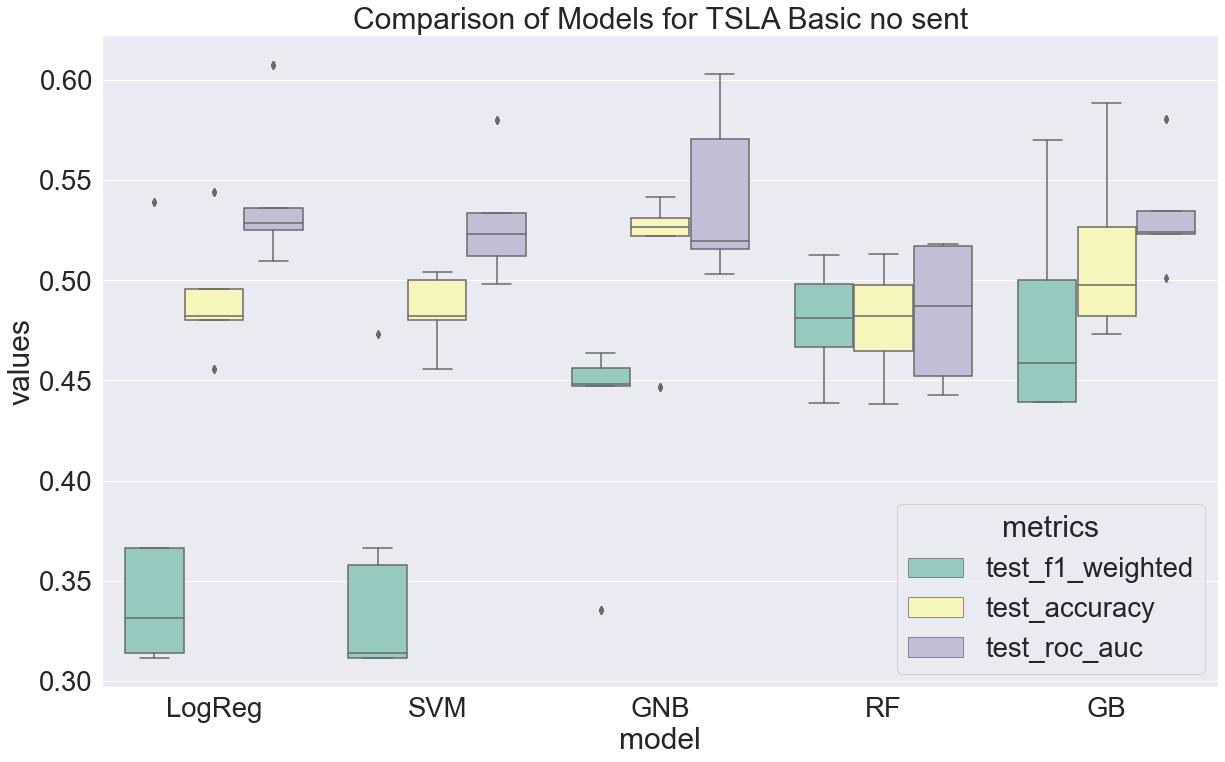

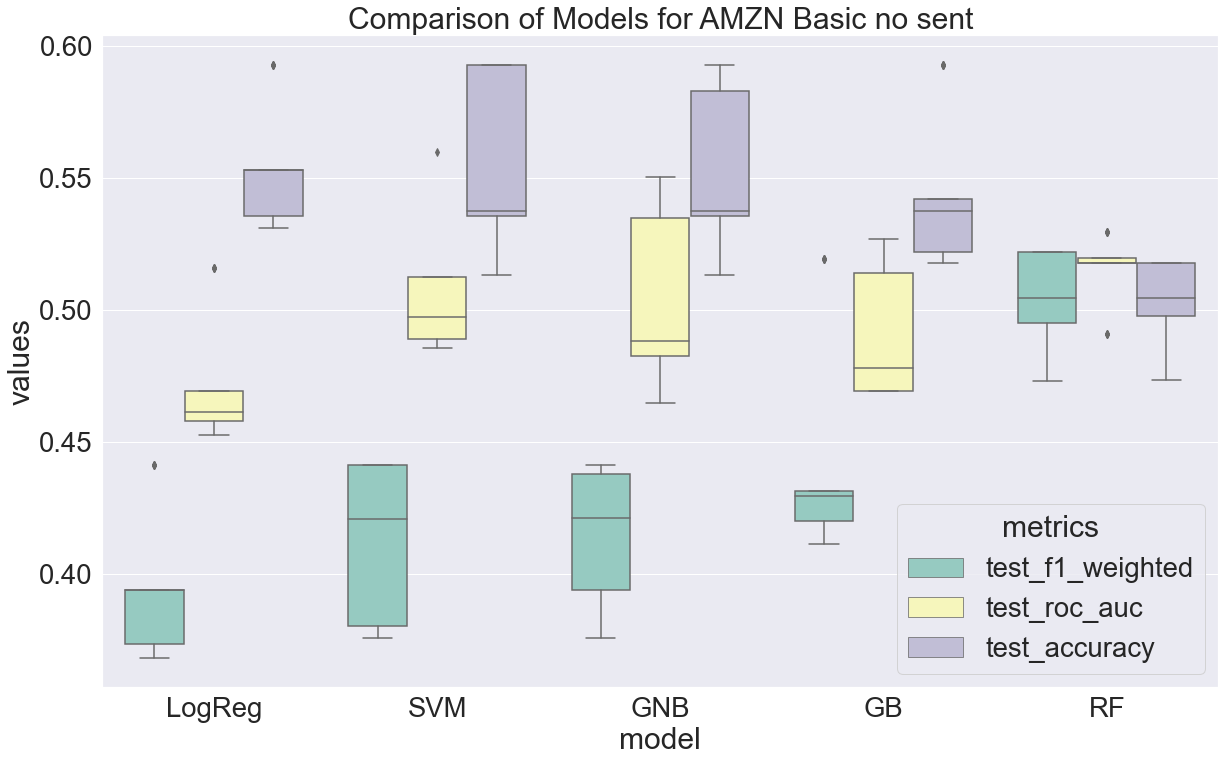

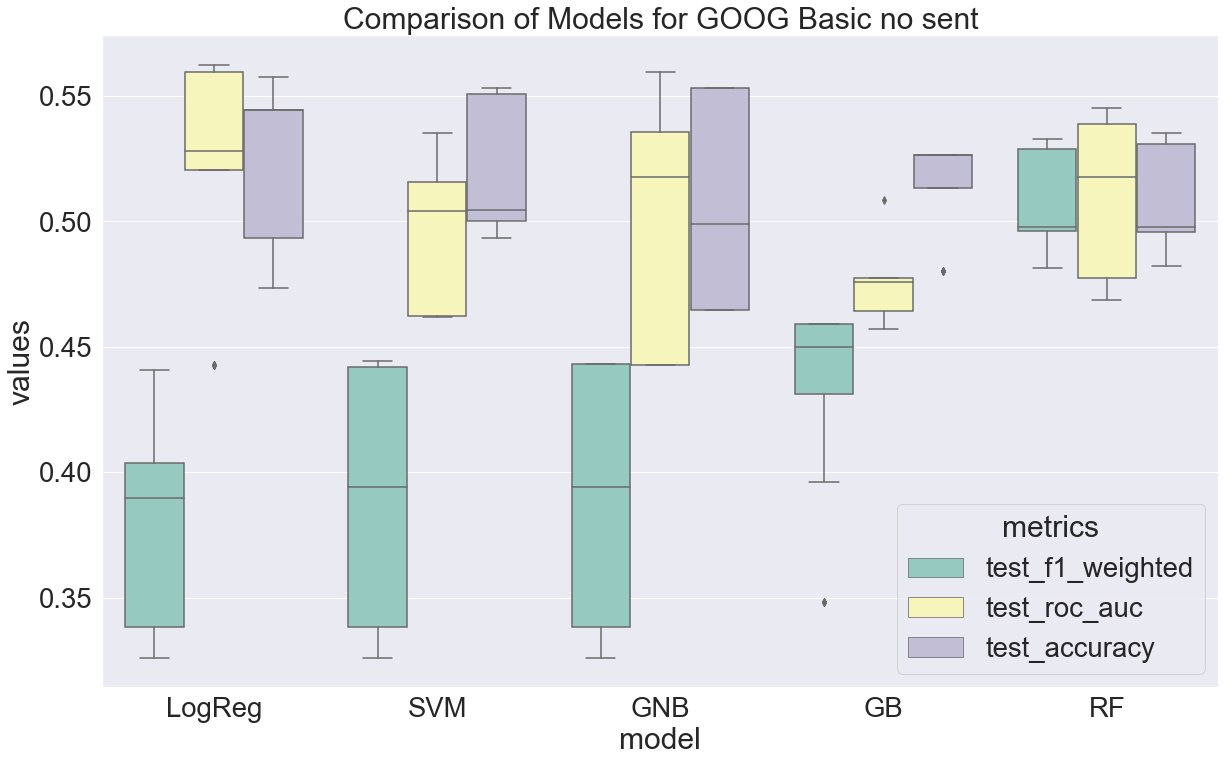

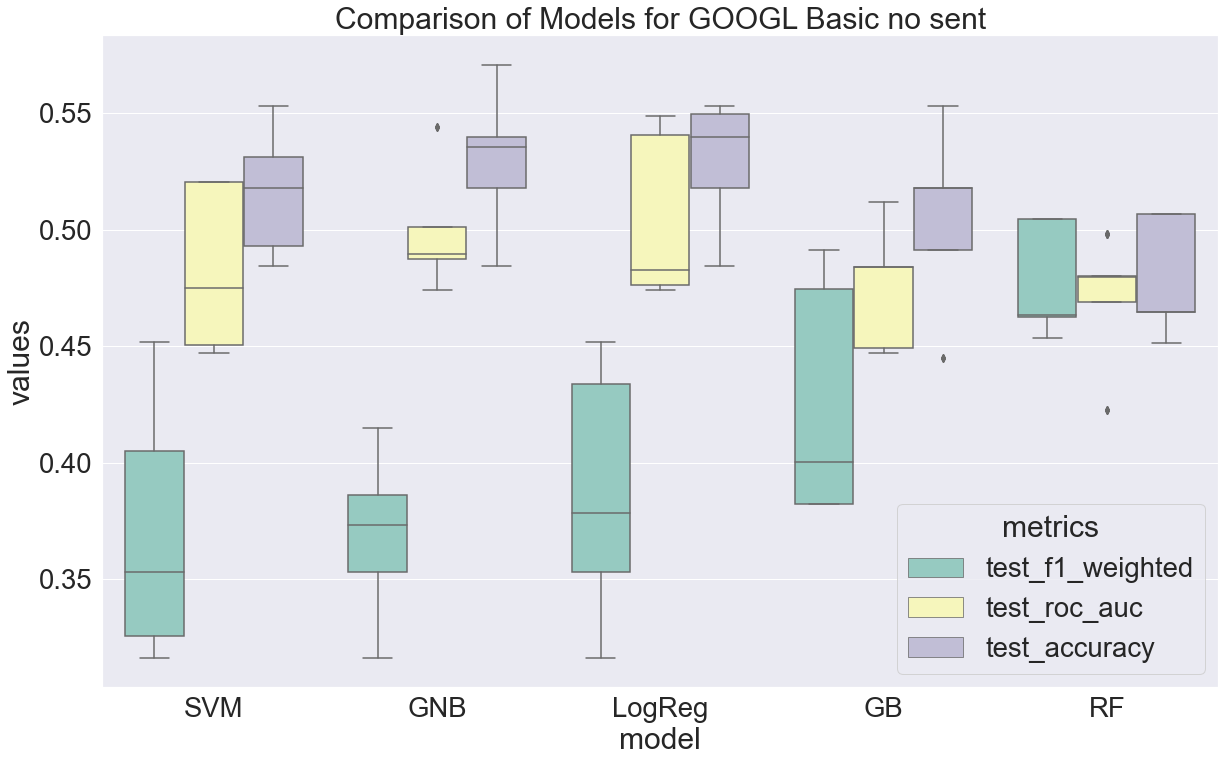

In [10]:
plot(aaplnofitb, 'AAPL Basic no sent')
plot(tslanofitb, 'TSLA Basic no sent')
plot(amznnofitb, 'AMZN Basic no sent')
plot(goognofitb, 'GOOG Basic no sent')
plot(googlnofitb, 'GOOGL Basic no sent')

### Complex

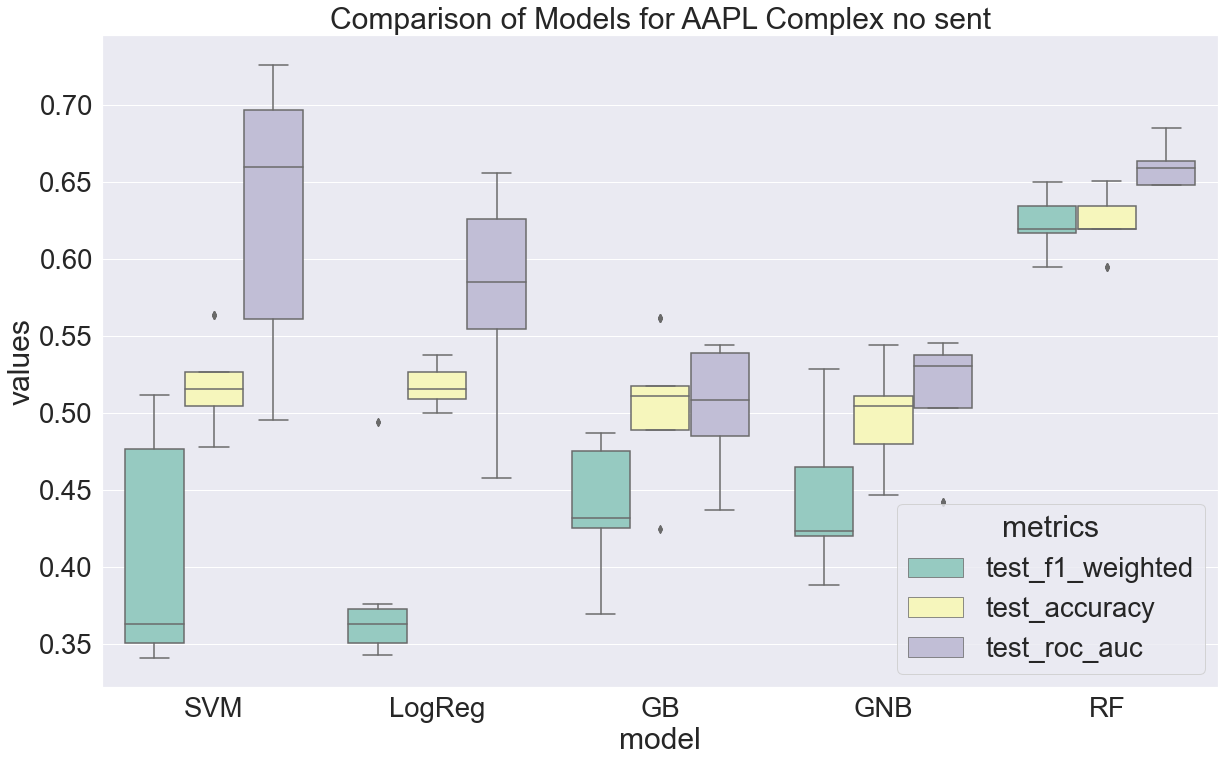

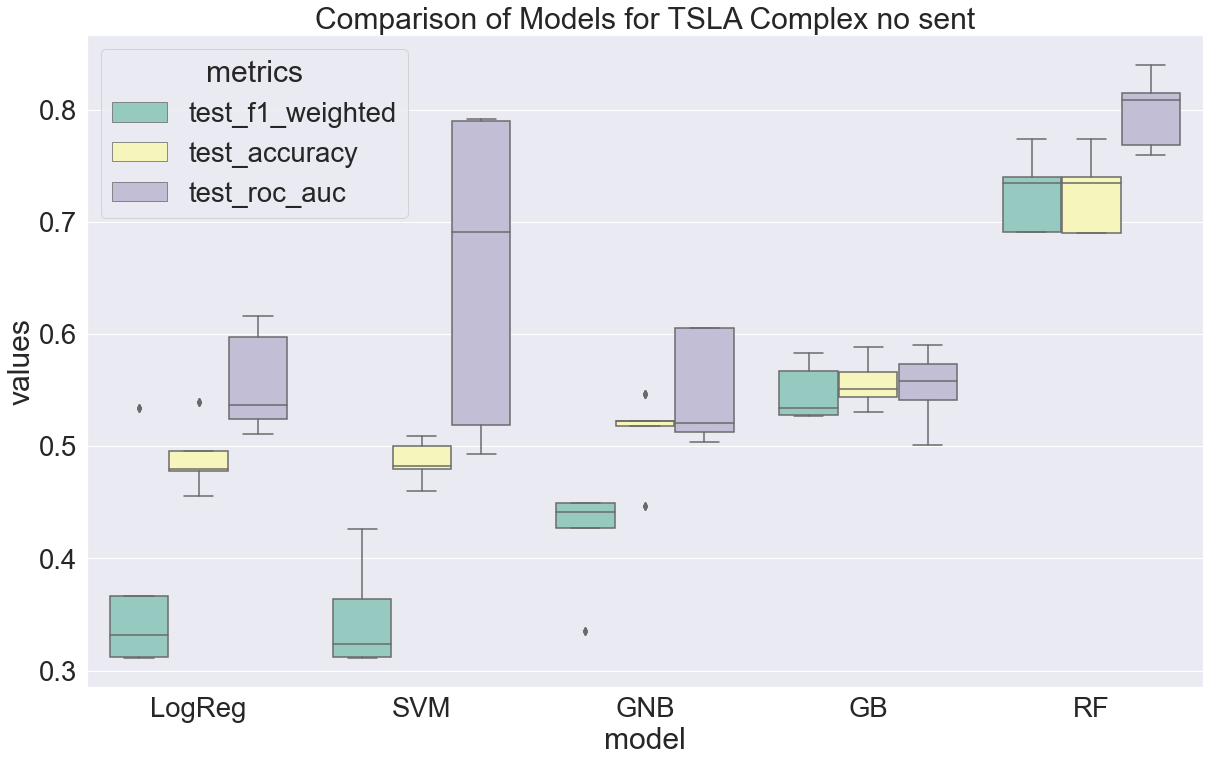

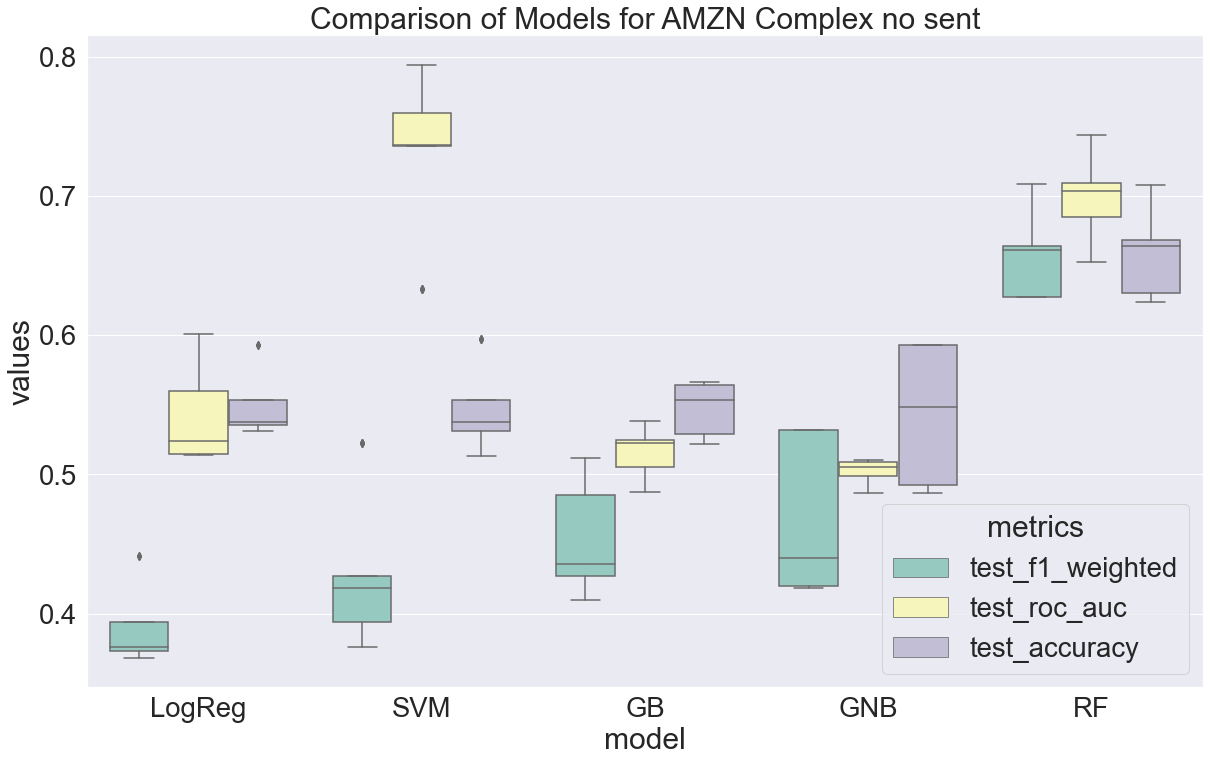

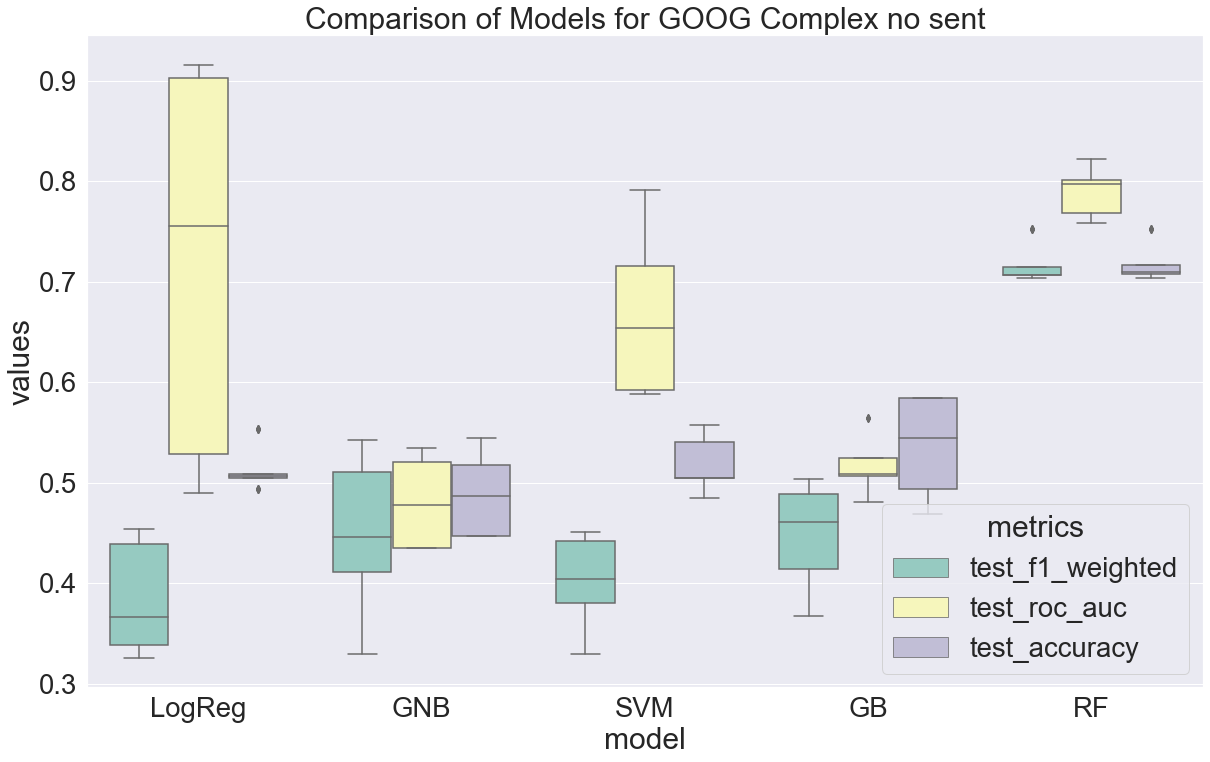

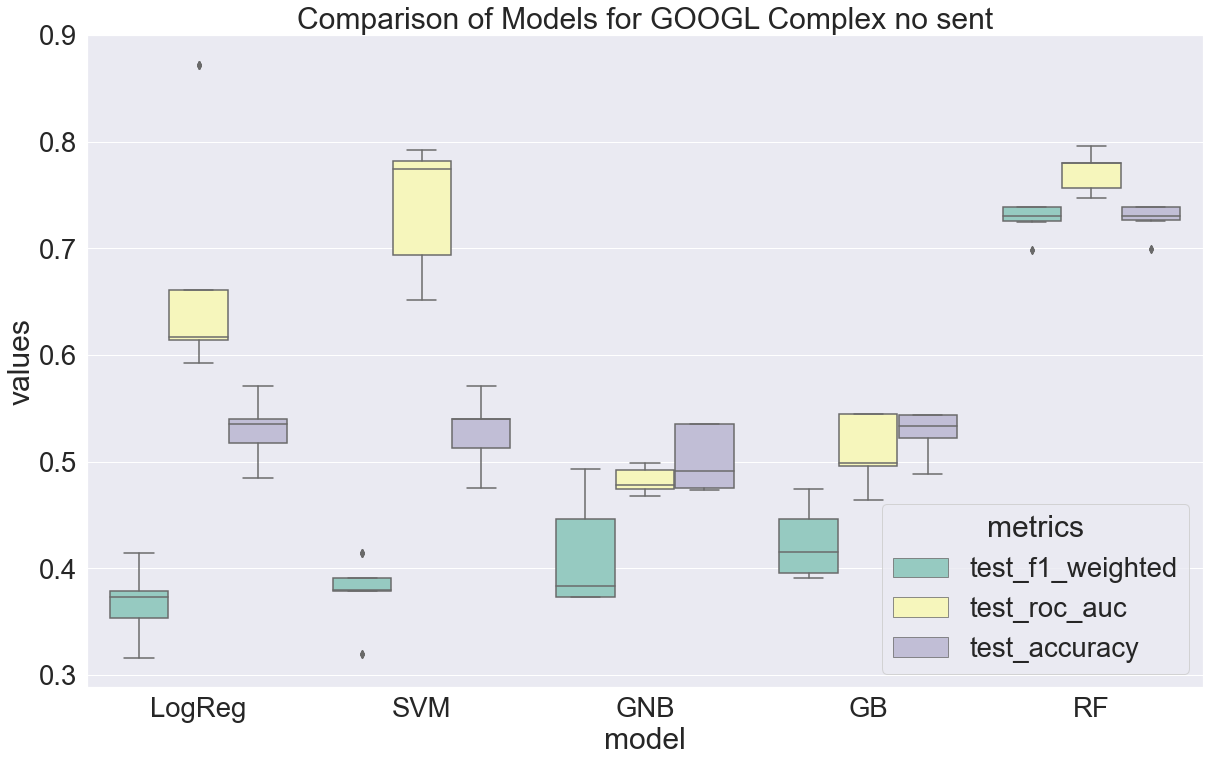

In [11]:
plot(aaplnofitc, 'AAPL Complex no sent')
plot(tslanofitc, 'TSLA Complex no sent')
plot(amznnofitc, 'AMZN Complex no sent')
plot(goognofitc, 'GOOG Complex no sent')
plot(googlnofitc, 'GOOGL Complex no sent')

# Twitter

## Simple EDA

In [12]:
filepath_companytweets = os.path.join(pwd, 'Company_Tweet.csv')
print(filepath_companytweets)
filepath_company = os.path.join(pwd, 'Company.csv')
print(filepath_company)
filepath_Tweet = os.path.join(pwd, 'Tweet.csv')
print(filepath_Tweet)

df_companytweets = pd.read_csv(filepath_companytweets)
df_company = pd.read_csv(filepath_company)
df_tweet = pd.read_csv(filepath_Tweet)

tweets = pd.merge(df_companytweets, df_tweet, on='tweet_id', how='inner')

tweets['Date'] = pd.to_datetime(tweets['post_date'], unit='s').dt.strftime('%Y-%m-%d')
tweets = tweets.drop(columns=['post_date'], axis=1)

c:\Users\harsh\Desktop\Using Tweets to predict Stock Movement\Company_Tweet.csv
c:\Users\harsh\Desktop\Using Tweets to predict Stock Movement\Company.csv
c:\Users\harsh\Desktop\Using Tweets to predict Stock Movement\Tweet.csv


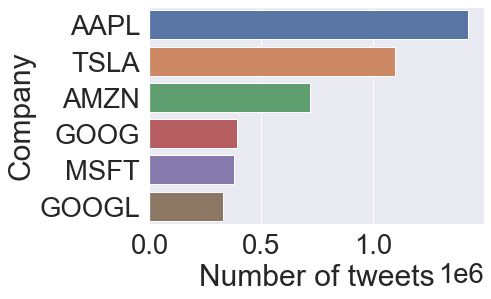

In [13]:
tweets_for_each_company = tweets['ticker_symbol'].value_counts()

sns.barplot(y=tweets_for_each_company.index, x=tweets_for_each_company.values)
plt.xlabel('Number of tweets')
plt.ylabel('Company')
plt.show()

In [14]:
tweets['engagement'] = tweets['comment_num'] + tweets['retweet_num'] + tweets['like_num']
engaged_tweets = tweets.copy()

## Sentiment Analysis

### Performing sent analysis

In [15]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def getSentiment(body):
    assert body is not None
    vs = analyzer.polarity_scores(body)
    score = vs['compound']
    return score

engaged_tweets['Sentiment'] = engaged_tweets['body'].apply(lambda x: getSentiment(x))

engaged_tweets = engaged_tweets.drop(columns=['comment_num', 'retweet_num', 'like_num',  'writer', 'tweet_id', 'body'], axis=1)

# Seperating tweets into smaller dataframes respective to their own ticker symbol
engaged_tweets['Date'] = pd.to_datetime(engaged_tweets['Date'])
symbols = engaged_tweets.groupby(['ticker_symbol'])
tesla_tweets = symbols.get_group('TSLA')
appl_tweets = symbols.get_group('AAPL')
amzn_tweets = symbols.get_group('AMZN')
googl_tweets = symbols.get_group('GOOGL')
goog_tweets = symbols.get_group('GOOG')

# calculating the average sentiment and engagment as well as the total 
# for the both for each day
def avg_and_total_sent_and_eng(df):
    df['avg_day_sent'] = (df['Sentiment'].groupby(df['Date']).transform('sum'))/df['Sentiment'].groupby(df['Date']).transform(len)
    df['total_sent'] = df['Sentiment'].groupby(df['Date']).transform('sum')
    df['avg_eng'] = (df['engagement'].groupby(df['Date']).transform('sum'))/df['engagement'].groupby(df['Date']).transform(len)
    df['total_eng'] = df['engagement'].groupby(df['Date']).transform('sum')
    return df

appl_tweets = avg_and_total_sent_and_eng(appl_tweets)
tesla_tweets = avg_and_total_sent_and_eng(tesla_tweets)
amzn_tweets = avg_and_total_sent_and_eng(amzn_tweets)
googl_tweets = avg_and_total_sent_and_eng(googl_tweets)
goog_tweets = avg_and_total_sent_and_eng(goog_tweets)

def remove_duplicate_dates(df):
    tweets_copy = df.copy()
    tweets_copy['Date'] = pd.to_datetime(tweets_copy["Date"])
    tweets_copy = tweets_copy.drop_duplicates('Date')
    tweets_copy.set_index('Date', inplace=True)
    tweets_copy = tweets_copy.drop(columns=['engagement', 'Sentiment'], axis=1)
    return tweets_copy

appl_tweets_copy = remove_duplicate_dates(appl_tweets)
tesla_tweets_copy = remove_duplicate_dates(tesla_tweets)
amzn_tweets_copy = remove_duplicate_dates(amzn_tweets)
googl_tweets_copy = remove_duplicate_dates(googl_tweets)
goog_tweets_copy = remove_duplicate_dates(goog_tweets)

C:\Users\harsh\AppData\Local\Temp/ipykernel_14056/947601219.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['avg_day_sent'] = (df['Sentiment'].groupby(df['Date']).transform('sum'))/df['Sentiment'].groupby(df['Date']).transform(len)
C:\Users\harsh\AppData\Local\Temp/ipykernel_14056/947601219.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_sent'] = df['Sentiment'].groupby(df['Date']).transform('sum')
C:\Users\harsh\AppData\Local\Temp/ipykernel_14056/947601219.py:28: SettingWithCopyWarni

### classification of sentiment

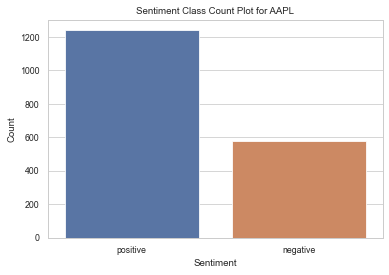

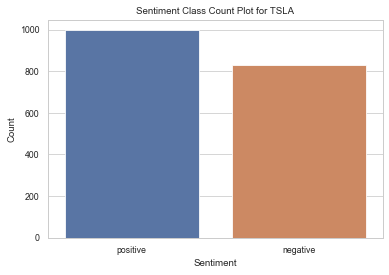

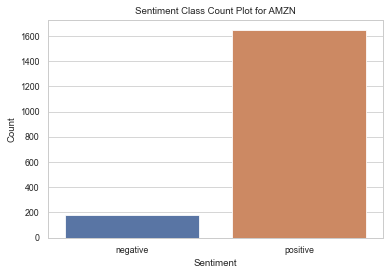

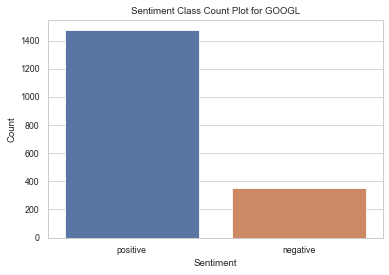

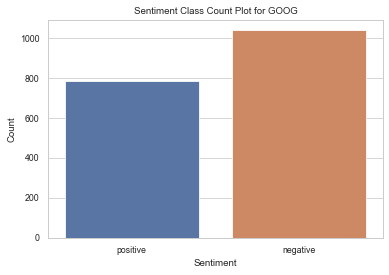

In [16]:
threshold = 0.1

def classifySentiment(score):
    if score > threshold:
        return 'positive'
    else:
        return 'negative'

    return score

def get_sentiment_class(df):
    df['sent_class'] = df['avg_day_sent'].apply(lambda x: classifySentiment(x))
    return df

appl_tweets = get_sentiment_class(appl_tweets_copy)
tesla_tweets = get_sentiment_class(tesla_tweets_copy)
amzn_tweets = get_sentiment_class(amzn_tweets_copy)
googl_tweets = get_sentiment_class(googl_tweets_copy)
goog_tweets = get_sentiment_class(goog_tweets_copy)

# make a count plot for the amount of positive, negative and neutral tweets
def countplot_for_sentclass(df):
    sns.set_style('whitegrid')
    sns.set_context('paper')
    sns.countplot(x='sent_class', data=df)
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.title('Sentiment Class Count Plot for ' + df['ticker_symbol'].unique()[0])
    plt.show()

countplot_for_sentclass(appl_tweets)
countplot_for_sentclass(tesla_tweets)
countplot_for_sentclass(amzn_tweets)
countplot_for_sentclass(googl_tweets)
countplot_for_sentclass(goog_tweets)



### Joining datasets

In [17]:
appl_tweets = resetIndex_and_changeDateType(appl_tweets)
tesla_tweets = resetIndex_and_changeDateType(tesla_tweets)
amzn_tweets = resetIndex_and_changeDateType(amzn_tweets)
googl_tweets = resetIndex_and_changeDateType(googl_tweets)
goog_tweets = resetIndex_and_changeDateType(goog_tweets)

df_appl = pd.merge(aapl, appl_tweets, on='Date')
df_tsla = pd.merge(tsla, tesla_tweets, on='Date')
df_amzn = pd.merge(amzn, amzn_tweets, on='Date')
df_goog = pd.merge(goog, goog_tweets, on='Date')
df_googl = pd.merge(googl, googl_tweets, on='Date')

In [18]:
df_appl.head()

,Date,Open,High,Low,Close,Adj Close,Volume,prevClose,change,upDown,ticker_symbol,avg_day_sent,total_sent,avg_eng,total_eng,sent_class
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.746000,212818400,NaN,NaN,Negative,AAPL,0.086860,75.3080,2.737024,2373,negative
1,2015-01-05,27.072500,27.162500,26.352501,26.562500,24.048864,257142000,24.746000,-0.028172,Negative,AAPL,0.143393,164.4715,1.003487,1151,positive
2,2015-01-06,26.635000,26.857500,26.157499,26.565001,24.051125,263188400,24.048864,0.000094,Positive,AAPL,0.161076,191.6800,0.684874,815,positive
3,2015-01-07,26.799999,27.049999,26.674999,26.937500,24.388378,160423600,24.051125,0.014022,Positive,AAPL,0.155337,169.9391,0.803473,879,positive
4,2015-01-08,27.307501,28.037500,27.174999,27.972500,25.325432,237458000,24.388378,0.038422,Positive,AAPL,0.174654,261.1078,1.088294,1627,positive


## ML

### Preprocessing

In [19]:
def onehot_encode(df, column_dict):
    df = df.copy()
    for column, prefix in column_dict.items():
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

def preprocess_inputs(df, scaler):
    df = df.copy()
    
    # One-hot encode the nominal features
    nominal_features = ['sent_class']
    df = onehot_encode(df, dict(zip(nominal_features, ['sent_class'])))
    df = df.iloc[1: , :]
    # Split df into X and y
    y = df['upDown'].copy()
    X = df.drop(columns=['upDown', 'ticker_symbol', 'Date'], axis=1).copy()
    
    # Scale and make my dataset
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    return X, y
    

In [20]:

# Just MinMax Scaler

X_appl, y_appl = preprocess_inputs(df_appl, MinMaxScaler())
X_tsla, y_tsla = preprocess_inputs(df_tsla, MinMaxScaler())
X_amzn, y_amzn = preprocess_inputs(df_amzn, MinMaxScaler())
X_goog, y_goog = preprocess_inputs(df_goog, MinMaxScaler())
X_googl, y_googl = preprocess_inputs(df_googl, MinMaxScaler())

# Minmax but with different feature range

# X_appl, y_appl = preprocess_inputs(df_appl, MinMaxScaler(feature_range=(0,2)))
# X_tsla, y_tsla = preprocess_inputs(df_tsla, MinMaxScaler(feature_range=(0,2)))
# X_amzn, y_amzn = preprocess_inputs(df_amzn, MinMaxScaler(feature_range=(0,2)))
# X_goog, y_goog = preprocess_inputs(df_goog, MinMaxScaler(feature_range=(0,2)))
# X_googl, y_googl = preprocess_inputs(googl, MinMaxScaler(feature_range=(0,2)))

# Using Standard Scaler   

# X_appl, y_appl = preprocess_inputs(df_appl, StandardScaler())
# X_tsla, y_tsla = preprocess_inputs(df_tsla, StandardScaler())
# X_amzn, y_amzn = preprocess_inputs(df_amzn, StandardScaler())
# X_goog, y_goog = preprocess_inputs(df_goog, StandardScaler())
# X_googl, y_googl = preprocess_inputs(df_googl, StandardScaler())

### Feature selection

In [21]:
#Using Sent class
basic_features = ['Adj Close', 'sent_class_positive', 'sent_class_negative']
complex_features = ['Adj Close', 'Open', 'High', 'Low', 'sent_class_positive', 'sent_class_negative']

# Using average day sentiment
# basic_features = ['Adj Close', 'avg_day_sent']
# complex_features = ['Adj Close', 'Open', 'High', 'Low', 'avg_day_sent']

# Using total_sent
# basic_features = ['Adj Close', 'total_sent']
# complex_features = ['Adj Close', 'Open', 'High', 'Low', 'total_sent']

# Using avg_eng
# basic_features = ['Adj Close', 'avg_eng']
# complex_features = ['Adj Close', 'Open', 'High', 'Low', 'avg_eng']

#Using total_eng
# basic_features = ['Adj Close', 'total_eng']
# complex_features = ['Adj Close', 'Open', 'High', 'Low', 'total_eng']

#Using total_eng and avg day sent
# basic_features = ['Adj Close', 'total_eng', 'avg_day_sent'] 
# complex_features = ['Adj Close', 'Open', 'High', 'Low', 'total_eng', 'avg_day_sent'] 

#Using avg_eng and sent class
# basic_features = ['Adj Close', 'avg_eng', 'sent_class_positive', 'sent_class_negative'] 
# complex_features = ['Adj Close', 'Open', 'High', 'Low', 'avg_eng', 'sent_class_positive', 'sent_class_negative']

#basic features (sent category)
def select_features(features, wanted_features):
    features = features.copy()
    features = features[wanted_features].copy()
    return features

# Complex Features (sent category)
def select_featuresw(features, wanted_features):
    features = features.copy()
    features = features[wanted_features].copy()
    return features

In [22]:
#Basic Feature set
X_appl_withoutb = select_features(X_appl, basic_features)
X_tsla_withoutb = select_features(X_tsla, basic_features)
X_amzn_withoutb = select_features(X_amzn, complex_features)
X_goog_withoutb = select_features(X_goog, complex_features)
X_googl_withoutb = select_features(X_googl, complex_features)

# Complex Feature set
X_appl_without = select_featuresw(X_appl, complex_features)
X_tsla_without = select_featuresw(X_tsla, complex_features)
X_amzn_without = select_featuresw(X_amzn, complex_features)
X_goog_without = select_featuresw(X_goog, complex_features)
X_googl_without = select_featuresw(X_googl, complex_features)

In [23]:
# splitting my data into test and train data 
def split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=42)

    return X_train, X_test, y_train, y_test

# With sentiment features
X_train_applb, X_test_applb, y_train_applb, y_test_applb = split(X_appl_withoutb, y_appl)
X_train_tslab, X_test_tslab, y_train_tslab, y_test_tslab = split(X_tsla_withoutb, y_tsla)
X_train_amznb, X_test_amznb, y_train_amznb, y_test_amznb = split(X_amzn_withoutb, y_amzn)
X_train_googb, X_test_googb, y_train_googb, y_test_googb = split(X_goog_withoutb, y_goog)
X_train_googlb, X_test_googlb, y_train_googlb, y_test_googlb = split(X_googl_withoutb, y_googl)

#Complex features
X_train_applc, X_test_applc, y_train_applc, y_test_applc = split(X_appl_without, y_appl)
X_train_tslac, X_test_tslac, y_train_tslac, y_test_tslac = split(X_tsla_without, y_tsla)
X_train_amznc, X_test_amznc, y_train_amznc, y_test_amznc = split(X_amzn_without, y_amzn)
X_train_googc, X_test_googc, y_train_googc, y_test_googc = split(X_goog_without, y_goog)
X_train_googlc, X_test_googlc, y_train_googlc, y_test_googlc = split(X_googl_without, y_googl)

## Algs

#### Getting results

In [24]:
print('Apple Basic with Sent')
final_aapl = run_exps(X_train_applb, y_train_applb, X_test_applb, y_test_applb)
print('Tesla Basic with Sent')
final_tsla = run_exps(X_train_tslab, y_train_tslab, X_test_tslab, y_test_tslab)
print('Amazon Basic with Sent')
final_amzn = run_exps(X_train_amznb, y_train_amznb, X_test_amznb, y_test_amznb)
print('Goog Basic with Sent')
final_goog = run_exps(X_train_googb, y_train_googb, X_test_googb, y_test_googb)
print('Googl Basic with Sent')
final_googl = run_exps(X_train_googlb, y_train_googlb, X_test_googlb, y_test_googlb)

print('Apple Complex With Sent')
final_aaplc = run_exps(X_train_applc, y_train_applc, X_test_applc, y_test_applc)
print('Tesla Complex With Sent')
final_tslac = run_exps(X_train_tslac, y_train_tslac, X_test_tslac, y_test_tslac)
print('Amazon Complex With Sent')
final_amznc = run_exps(X_train_amznc, y_train_amznc, X_test_amznc, y_test_amznc)
print('Goog Complex With Sent')
final_googc = run_exps(X_train_googc, y_train_googc, X_test_googc, y_test_googc)
print('Googl Complex With Sent')
final_googlc = run_exps(X_train_googlc, y_train_googlc, X_test_googlc, y_test_googlc)

Apple Basic with Sent
LogReg
              precision    recall  f1-score   support

   malignant       0.56      0.47      0.51       157
      benign       0.54      0.62      0.58       157

    accuracy                           0.55       314
   macro avg       0.55      0.55      0.55       314
weighted avg       0.55      0.55      0.55       314

RF
              precision    recall  f1-score   support

   malignant       0.52      0.50      0.51       157
      benign       0.52      0.53      0.52       157

    accuracy                           0.52       314
   macro avg       0.52      0.52      0.52       314
weighted avg       0.52      0.52      0.52       314

SVM
              precision    recall  f1-score   support

   malignant       0.56      0.47      0.51       157
      benign       0.54      0.62      0.58       157

    accuracy                           0.55       314
   macro avg       0.55      0.55      0.55       314
weighted avg       0.55      0.55     

In [25]:
aaplnofitb, aaplfitb = metrics(final_aapl)
tslanofitb, tslafitb = metrics(final_tsla)
amznnofitb, amznfitb = metrics(final_amzn)
goognofitb, googfitb = metrics(final_goog)
googlnofitb, googlfitb = metrics(final_googl)

aaplnofitc, aaplfitc = metrics(final_aaplc)
tslanofitc, tslafitc = metrics(final_tslac)
amznnofitc, amznfitc = metrics(final_amznc)
goognofitc, googfitc = metrics(final_googc)
googlnofitc, googlfitc = metrics(final_googlc)

#### Basic Features

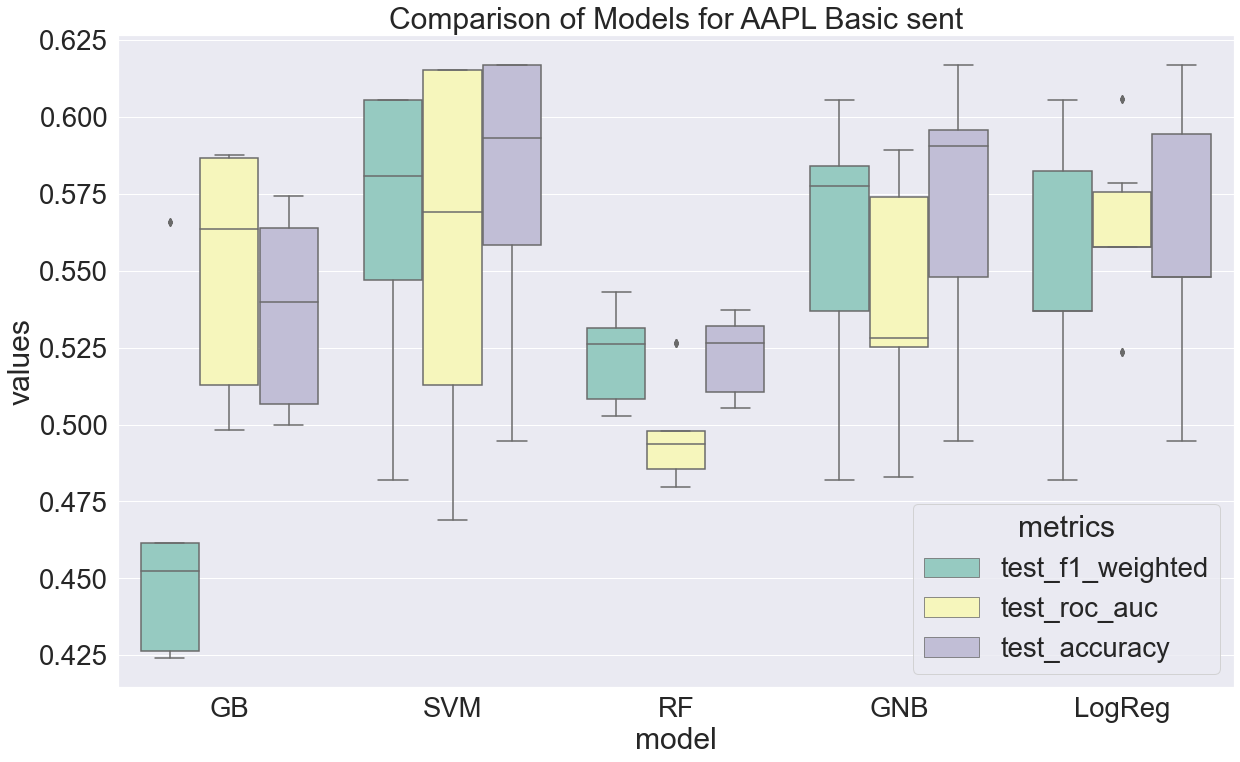

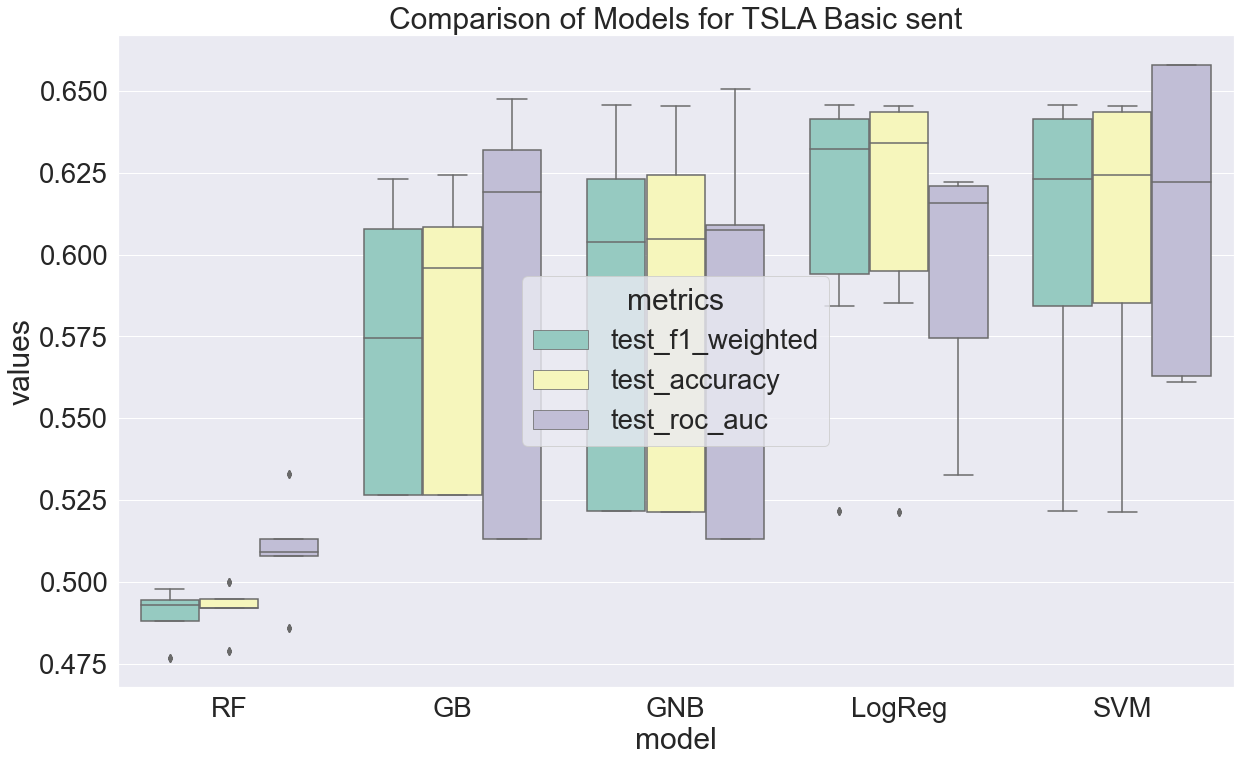

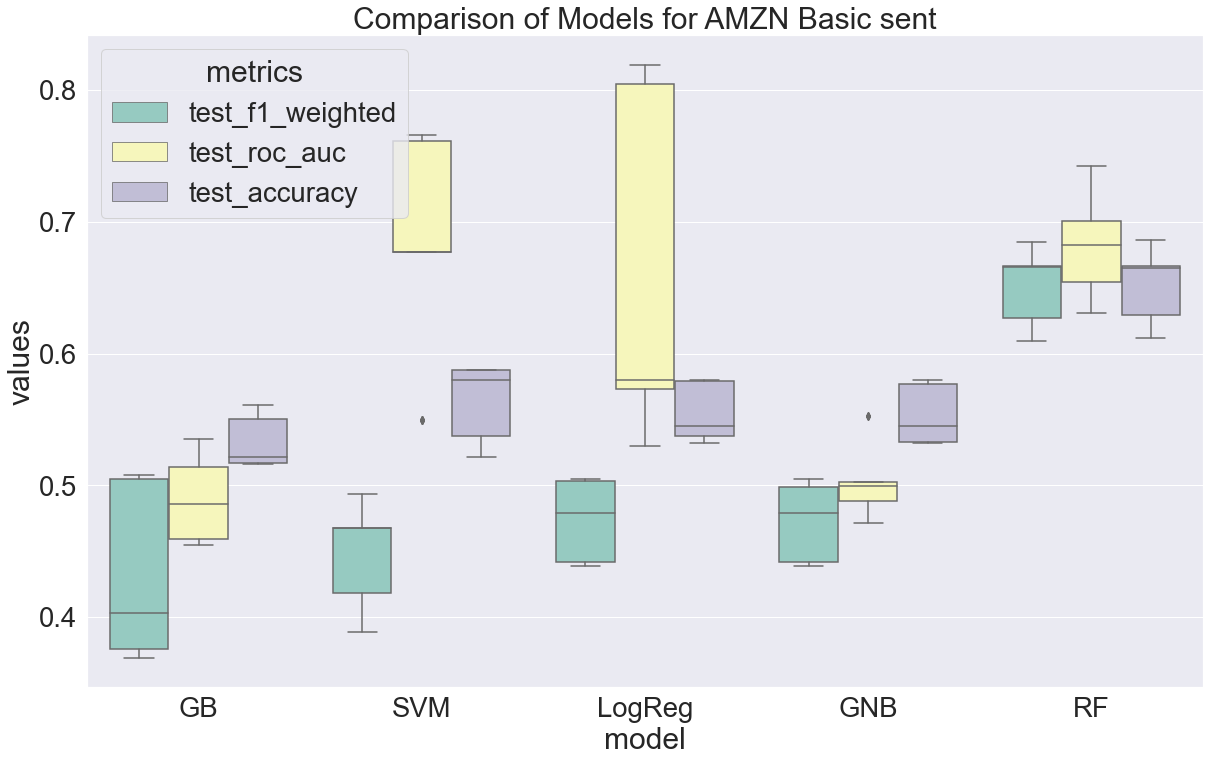

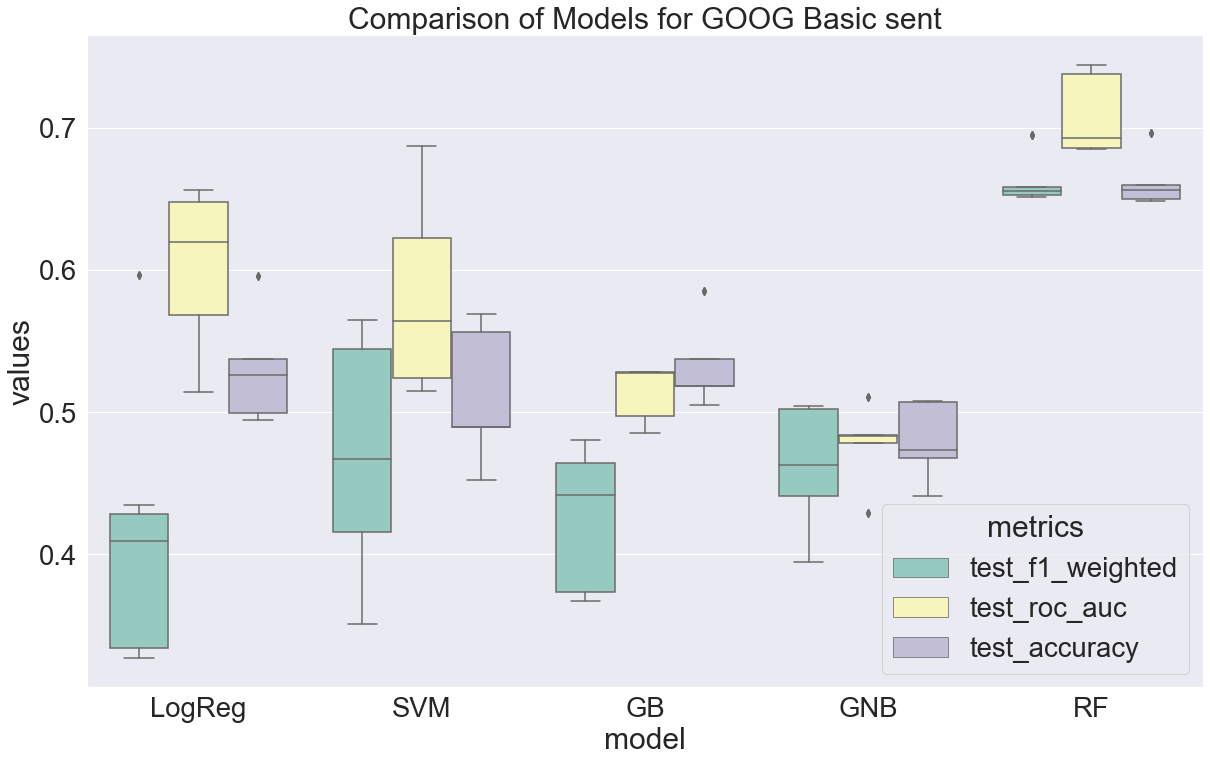

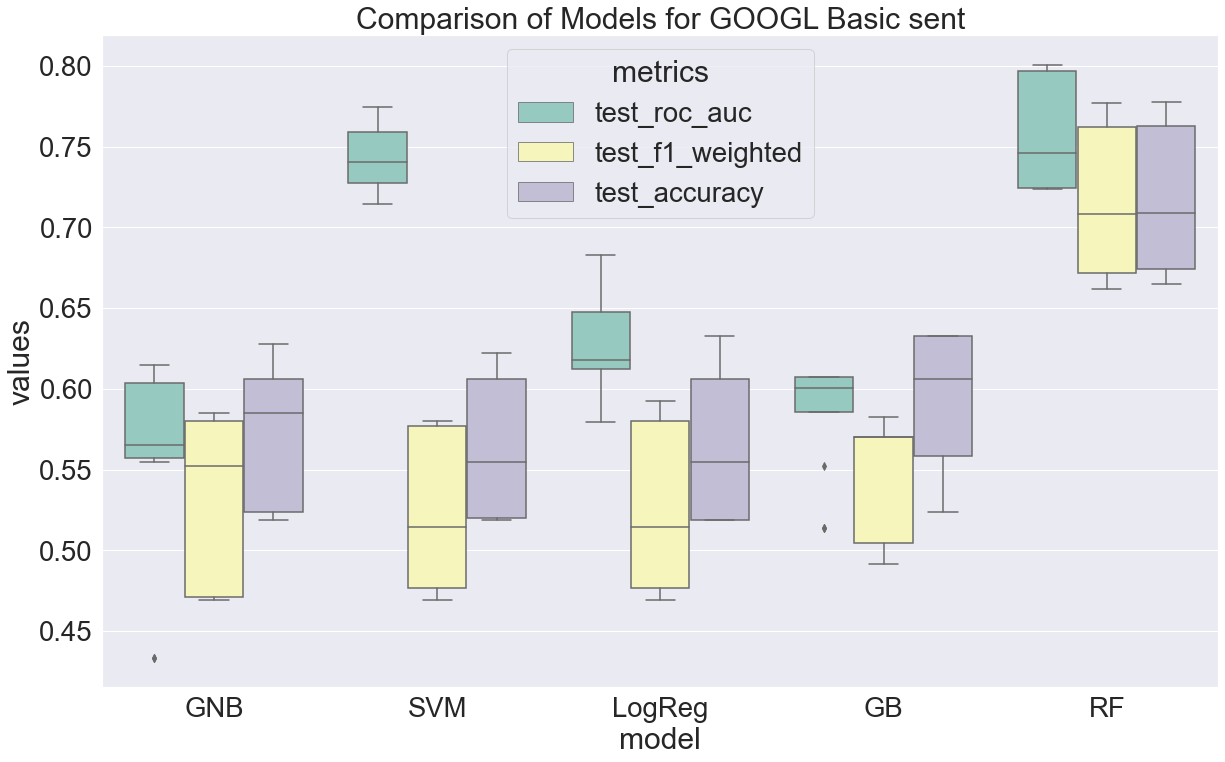

In [26]:
plot(aaplnofitb, 'AAPL Basic sent')
plot(tslanofitb, 'TSLA Basic sent')
plot(amznnofitb, 'AMZN Basic sent')
plot(goognofitb, 'GOOG Basic sent')
plot(googlnofitb, 'GOOGL Basic sent')

#### Complex Features

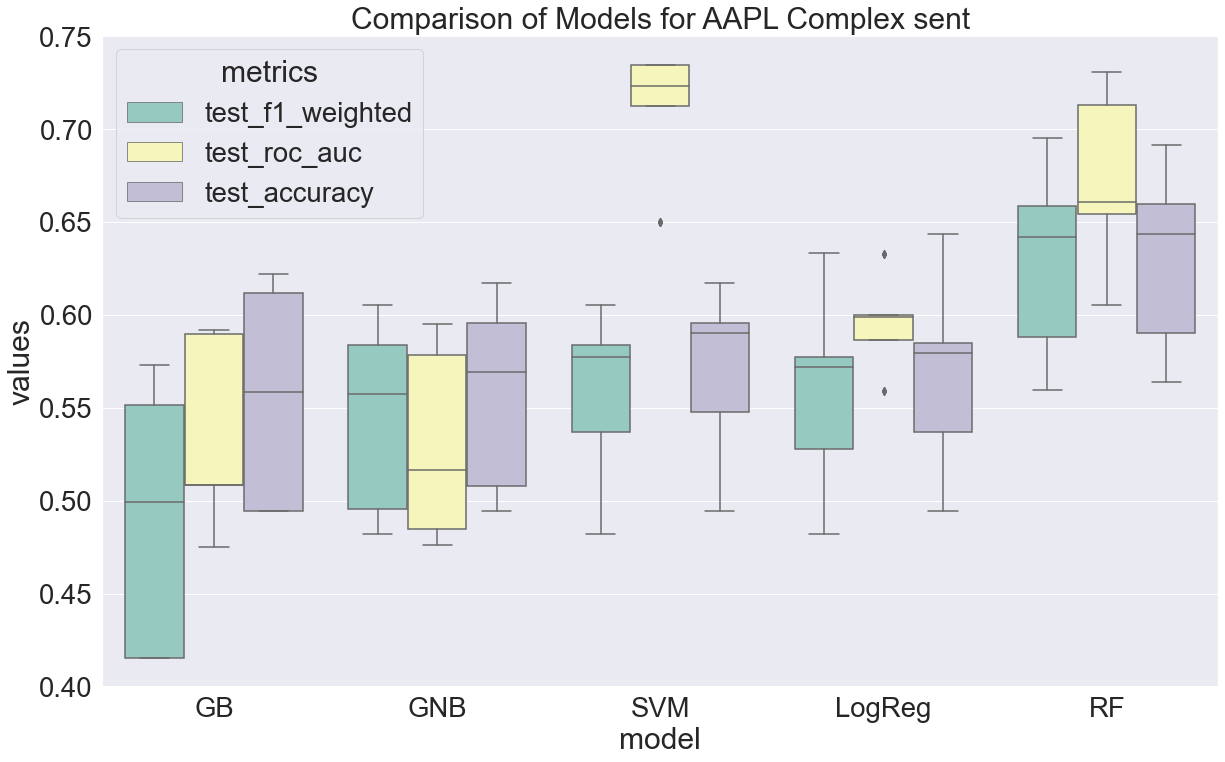

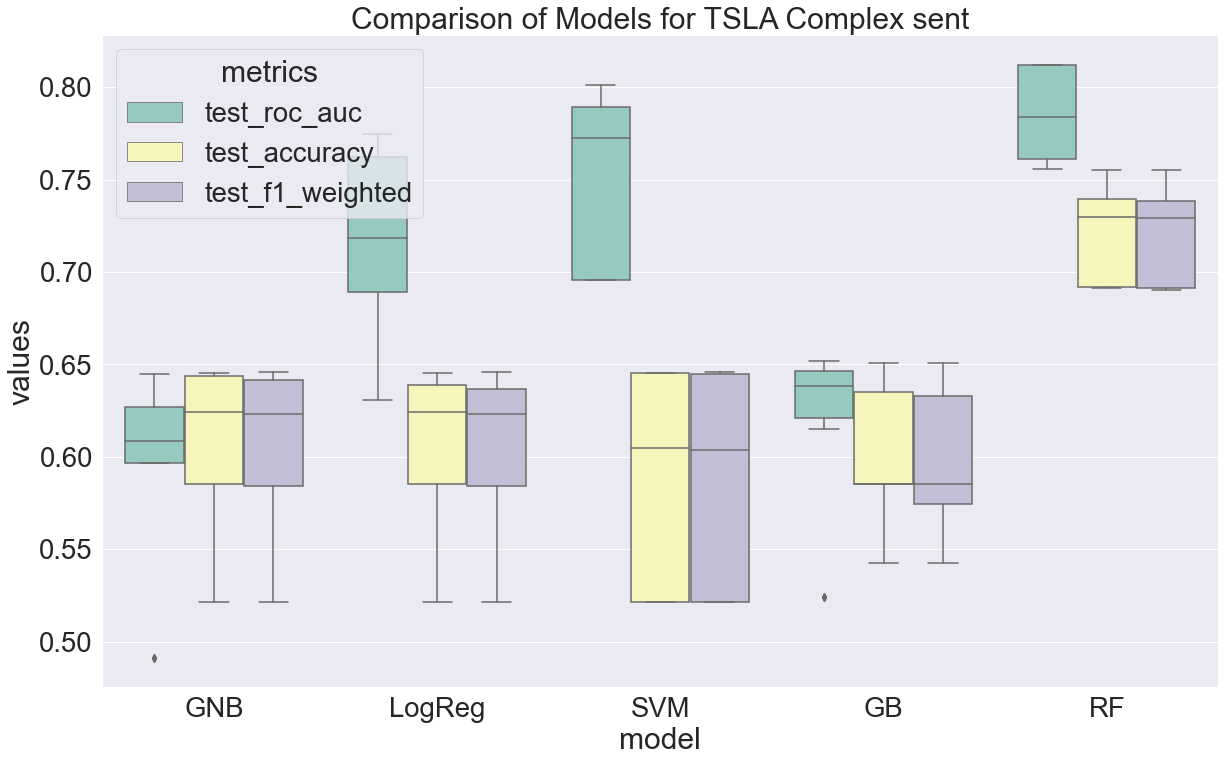

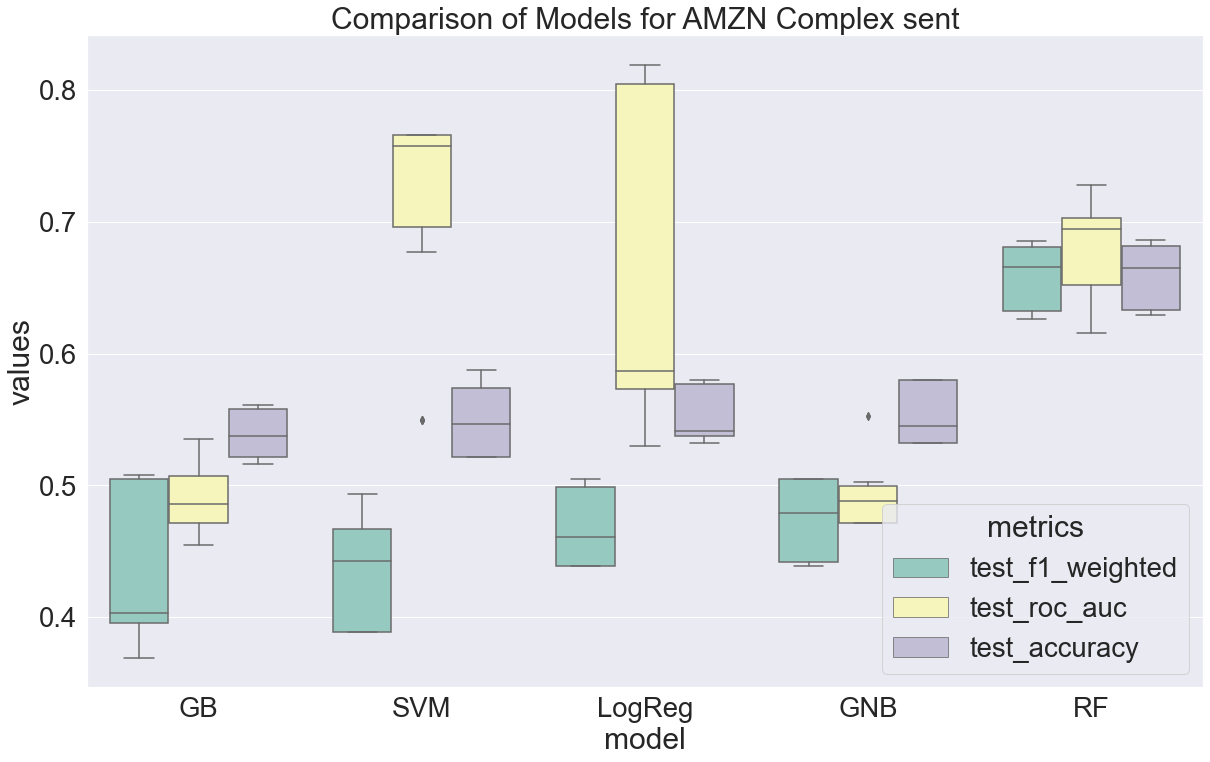

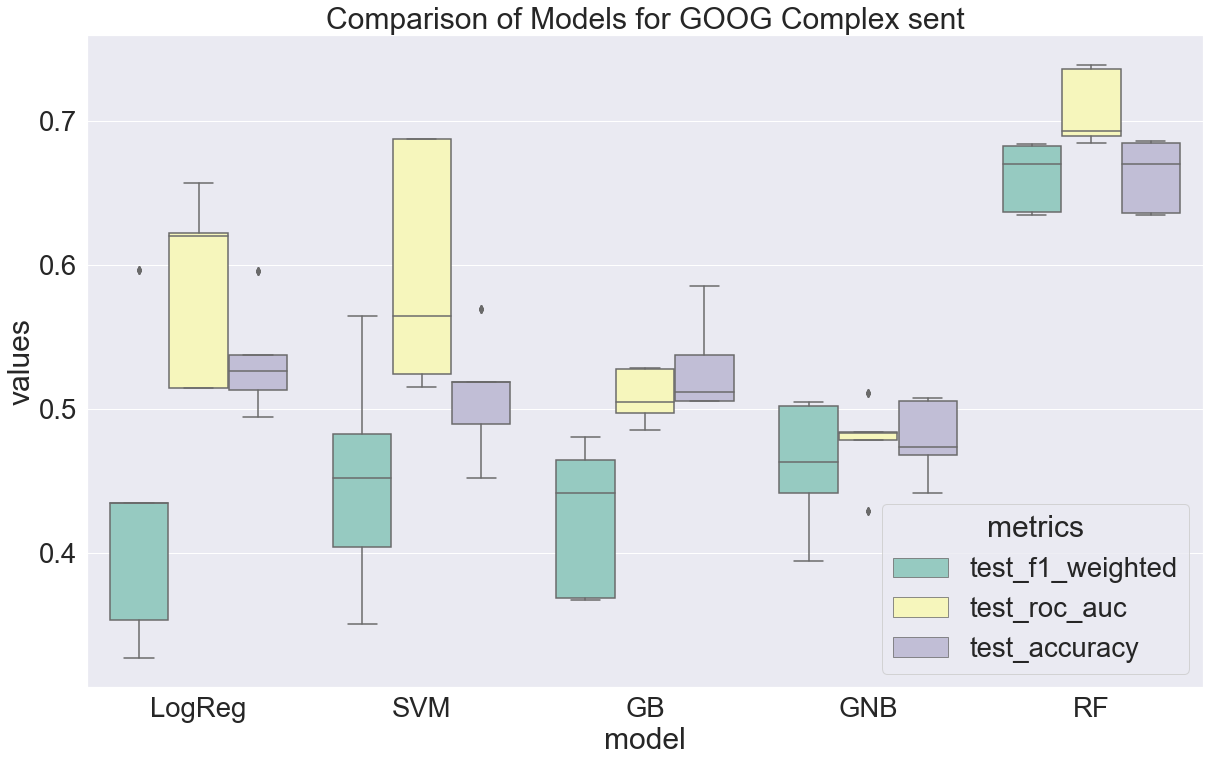

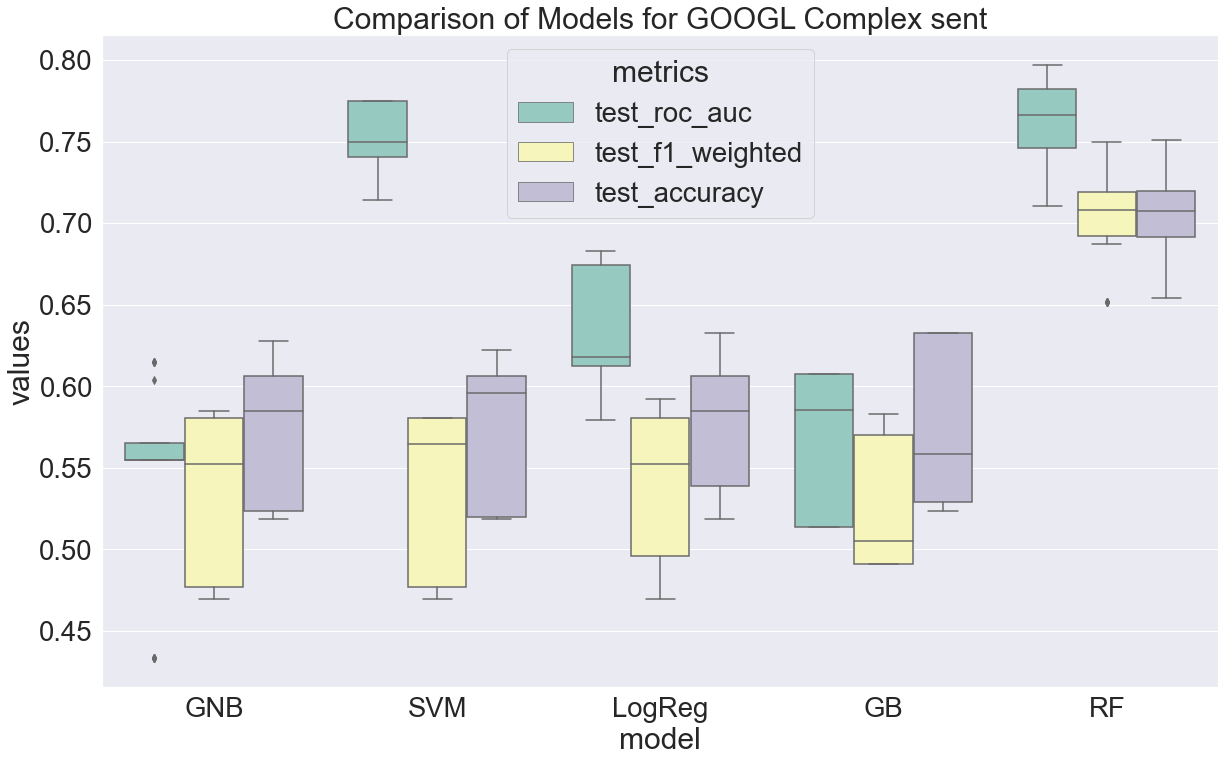

In [27]:
plot(aaplnofitc, 'AAPL Complex sent')
plot(tslanofitc, 'TSLA Complex sent')
plot(amznnofitc, 'AMZN Complex sent')
plot(goognofitc, 'GOOG Complex sent')
plot(googlnofitc, 'GOOGL Complex sent')